# Generative Deep Learning
# CIFAR 10 - Convolutional Network

In [4]:
import sys
sys.path.append('../code/')

import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

from itertools import islice as take

import dmodels.dnn as dnn

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [10]:
data_tsfm = transforms.Compose([transforms.ToTensor()])
cifar_train = datasets.CIFAR10('../data/cifar10', train=True, transform=data_tsfm, target_transform=None, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


## Describe Data

In [11]:
print(f'Data source: {cifar_train.url}')
print(f'Training examples and size: {cifar_train.data.shape, type(cifar_train.data)}')
print(f'Number of Classes: {len(cifar_train.classes)}')
print(f'Classes: {cifar_train.classes}')

Data source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Training examples and size: ((50000, 32, 32, 3), <class 'numpy.ndarray'>)
Number of Classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
classes = cifar_train.classes

In [13]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8,5))
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

## Display some images

image size: (32, 32, 3) dtype=uint8


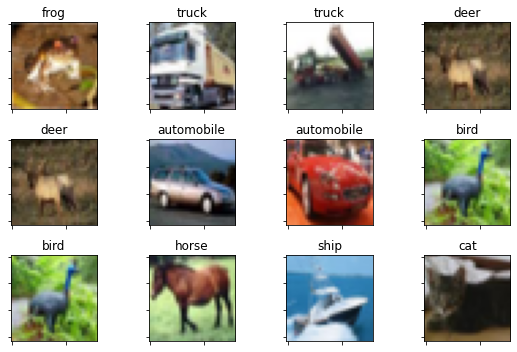

In [14]:
images, labels = [], []
for i in range(12):
    x_item, y_item = cifar_train.data[i] , classes[cifar_train.targets[i]]
    images.append(x_item)
    labels.append(y_item)


print(f'image size: {images[0].shape} dtype={images[0].dtype}')
titles = [str(y_item) for y_item in labels]
display_grid(images, titles, 3, 4)

## Loading our Model

In [15]:
device = torch.device("cpu")
print(device)

cpu


In [16]:
model = dnn.ConvNet()
model.to(device)
print(summary(model, (3,32,32), device='cpu', verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─LeakyReLU: 1-3                         [-1, 32, 32, 32]          --
├─Conv2d: 1-4                            [-1, 32, 16, 16]          9,248
├─BatchNorm2d: 1-5                       [-1, 32, 16, 16]          64
├─LeakyReLU: 1-6                         [-1, 32, 16, 16]          --
├─Conv2d: 1-7                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─LeakyReLU: 1-9                         [-1, 64, 16, 16]          --
├─Conv2d: 1-10                           [-1, 64, 8, 8]            36,928
├─BatchNorm2d: 1-11                      [-1, 64, 8, 8]            128
├─LeakyReLU: 1-12                        [-1, 64, 8, 8]            --
├─Flatten: 1-13                          [-1, 4096]                --
├

### Test imput-output shapes

In [17]:
x_fake = torch.zeros(1, 3, 32, 32)
y_fake = model(x_fake)
print(f'INPUT:{x_fake.shape} => OUTPUT:{y_fake.shape}')

INPUT:torch.Size([1, 3, 32, 32]) => OUTPUT:torch.Size([1, 10])


## Train Data Loader

In [18]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=cifar_train, batch_size=BATCH_SIZE, shuffle=True)
for x, y in take(train_loader, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'X mean: {x.mean():.4f}, X std: {x.std():.4f}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
X mean: 0.4580, X std: 0.2452
y shape=torch.Size([32]) dtype=torch.int64


## Training

In [19]:
%%time

EPOCHS = 10
LEARNING_RATE = 0.0005
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() # clear residual gradients 
        
        y_pred = model(X_batch)
        
        loss_calc = loss(y_pred, y_batch)

        
        loss_calc.backward()
        optimizer.step()
        
        epoch_loss += loss_calc.item()

        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 2.02234
Epoch 002: | Loss: 1.92765
Epoch 003: | Loss: 1.87342
Epoch 004: | Loss: 1.82897
Epoch 005: | Loss: 1.79519
Epoch 006: | Loss: 1.77011
Epoch 007: | Loss: 1.74817
Epoch 008: | Loss: 1.73345
Epoch 009: | Loss: 1.71712
Epoch 010: | Loss: 1.70332
CPU times: user 32min 42s, sys: 2.51 s, total: 32min 44s
Wall time: 8min 12s


# Comparing with Test Set

## Loading Test Data

In [20]:
transforms.Compose([transforms.ToTensor()])
cifar_test = datasets.CIFAR10('../data/cifar10',
                              train=False,
                              transform=data_tsfm,
                              target_transform=None,
                              download=True)

Files already downloaded and verified


In [21]:
print(f'Data source: {cifar_test.url}')
print(f'Training examples and size: {cifar_test.data.shape, type(cifar_test.data)}')
print(f'Number of Classes: {len(cifar_test.classes)}')
print(f'Classes: {cifar_test.classes}')

Data source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Training examples and size: ((10000, 32, 32, 3), <class 'numpy.ndarray'>)
Number of Classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Test Data Loader

In [22]:
test_loader = DataLoader(dataset=cifar_test, batch_size=BATCH_SIZE, shuffle=True)
for x, y in take(test_loader, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## Predictions

In [24]:
x_tensors = []
y_true_labels = []
y_pred_labels = []

accs = []

model.eval()
with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        
        y_logits = model(X_batch)
        y_prob = F.softmax(y_logits, 1)
        y_pred = torch.argmax(y_prob, 1)
        
        acc = (y_true == y_pred).type(torch.float32).mean()
        accs.append(acc.item() * 100)
                  
        x_tensors.append(X_batch)
        y_true_labels.append(y_true)
        y_pred_labels.append(y_pred)
        
    acc = np.mean(accs)

print(f'Predicted batches: {len(y_pred_labels)}')
print(f'Accuracy = {acc:.2f}')

Predicted batches: 313
Accuracy = 71.76


In [25]:
y_pred = [t.numpy() for t in y_pred_labels]
y_pred = np.hstack(y_pred)
print(y_pred.shape)
print(y_pred)

(10000,)
[7 1 0 ... 6 4 8]


In [26]:
y_true = [t.numpy() for t in y_true_labels]
y_true = np.hstack(y_true)
print(y_true.shape)
print(y_true)

(10000,)
[2 9 2 ... 6 2 8]


In [27]:
x_images = []
for T in x_tensors:
    for t in T:
        t = t.permute(1, 2, 0)
        x_images.append(t)

## Accuracy and Confusion Matrix

Accuracy: 0.7175

              precision    recall  f1-score   support

    airplane       0.77      0.68      0.72      1000
  automobile       0.86      0.81      0.83      1000
        bird       0.60      0.58      0.59      1000
         cat       0.59      0.47      0.52      1000
        deer       0.64      0.73      0.68      1000
         dog       0.70      0.57      0.63      1000
        frog       0.73      0.84      0.79      1000
       horse       0.70      0.82      0.76      1000
        ship       0.76      0.89      0.82      1000
       truck       0.82      0.77      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000



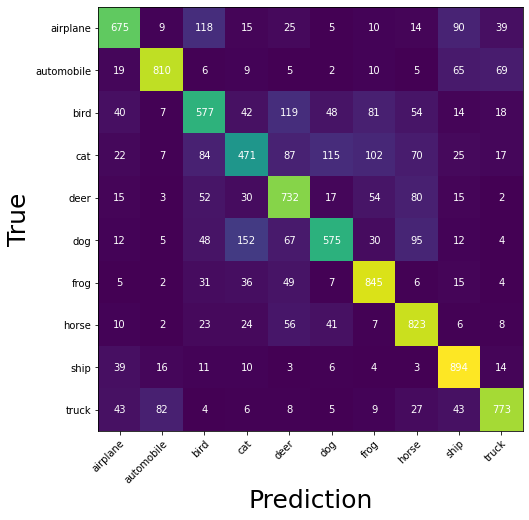

In [30]:
print(f'Accuracy: {(np.array(y_true) == y_pred).sum() / len(y_true)}')

print(f'\n{classification_report(y_true, y_pred, target_names=classes)}')
c_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(c_matrix)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(10):
    for j in range(10):
        text = ax.text(j, i, c_matrix[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('True', fontsize=25)
plt.show()

## Plot Test Examples

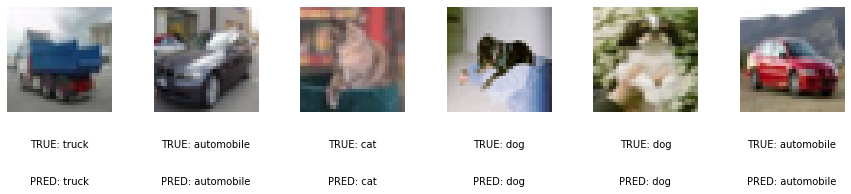

In [34]:
n_to_show = 6
indices = np.random.choice(range(len(x_images)), n_to_show)
fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_images[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'TRUE: '+classes[y_true[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'PRED: '+classes[y_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)